In [1]:
from torchvision import datasets, transforms
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

np.random.seed(50)


# Load and Preprocess dataset

In [2]:
def load_data(train):
    # Define transformation
    transform = transforms.ToTensor()
    
    # Load data
    if train :
        train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        train_x = train_dataset.data.reshape((-1, 28*28)).float().numpy()
        train_y = train_dataset.targets.numpy()

        return train_x, train_y
    
    else:
        test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
        test_x = test_dataset.data.reshape((-1, 28*28)).float().numpy()
        test_y = test_dataset.targets.numpy()
        return test_x, test_y
    

def preprocess_data(x,y) :
    x = x / 255.0
        
    num_classes = len(np.unique(y))
    y = np.eye(num_classes)[y]

    return x, y


# Feed Forward Neural Network

In [3]:
def xaiver_init(n_in, n_out):
    return np.random.randn(n_in, n_out) * np.sqrt(2/(n_in+n_out))


class Layer: 
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        raise NotImplementedError()
    
    def backward(self, output_grad, learning_rate):
        raise NotImplementedError()
    

class Optimizer:
    def __init__(self):
        pass

    def update(self, weight, bias, weight_grad, bias_grad):
        raise NotImplementedError()
    
class MiniBatchGradientDescent(Optimizer):
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, weight, bias, weight_grad, bias_grad):
        weight -= self.learning_rate * weight_grad
        bias -= self.learning_rate * bias_grad
        
        return weight, bias
    
class AdamOptimizer(Optimizer):
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_w, self.v_w = None, None
        self.m_b, self.v_b = None, None
        self.t = 0

    def update(self, weight, bias, weight_grad, bias_grad):
        # Initialize moving averages with the shape of weights and biases on the first call
        if self.m_w is None:
            self.m_w = np.zeros_like(weight)
            self.v_w = np.zeros_like(weight)
            self.m_b = np.zeros_like(bias)
            self.v_b = np.zeros_like(bias)

        # Increment timestep
        self.t += 1

        # Update moving averages of gradients
        self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * weight_grad
        self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * (weight_grad ** 2)
        m_w_hat = self.m_w / (1 - self.beta1 ** self.t)
        v_w_hat = self.v_w / (1 - self.beta2 ** self.t)
        weight -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)

        # Update moving averages for bias
        self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * bias_grad
        self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * (bias_grad ** 2)
        m_b_hat = self.m_b / (1 - self.beta1 ** self.t)
        v_b_hat = self.v_b / (1 - self.beta2 ** self.t)
        bias -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        return weight, bias

    

class Dense(Layer):
    def __init__(self, n_in, n_out, initializer=xaiver_init, optimizer=None):
        self.weight = initializer(n_in, n_out)
        self.bias = initializer(1, n_out)
        self.optimizer = optimizer if optimizer is not None else AdamOptimizer(0.001)
        self.weight_grad = None
        self.bias_grad = None

    def forward(self, input):
        self.input = input
        self.output = np.dot(input, self.weight) + self.bias
        return self.output
    
    def backward(self, output_grad, learning_rate):
        input_grad = np.dot(output_grad, self.weight.T)
        self.weight_grad = np.dot(self.input.T, output_grad)
        self.bias_grad = np.sum(output_grad, axis=0)
        self.weight, self.bias = self.optimizer.update(self.weight, self.bias, self.weight_grad, self.bias_grad)
        return input_grad

    
class ReLu(Layer):
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        self.input = input
        self.output = np.maximum(0, input)
        return self.output
    
    def backward(self, output_grad, learning_rate):
        return output_grad * (self.input > 0)
    

class Softmax(Layer):
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # Shift inputs for numerical stability
        exp = np.exp(input - np.max(input, axis=1, keepdims=True))
        self.output = exp / np.sum(exp, axis=1, keepdims=True)
        return self.output

    def backward(self, y_true, learning_rate=None):
        # Directly return the gradient for softmax + cross-entropy
        return y_true



class Dropout(Layer):
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate
        self.input = None
        self.output = None
        self.mask = None

    def forward(self, input, train=True):
        self.input = input
        if train:
            self.mask = (np.random.rand(*input.shape) > self.dropout_rate) / (1 - self.dropout_rate)
            self.output = input * self.mask
        else:
            self.output = input
        return self.output
    
    def backward(self, output_grad, learning_rate):
        return np.multiply(output_grad, self.mask) / (1 - self.dropout_rate)
    


In [4]:
def cross_entropy_loss(y_true, y_pred):
    # Clip predictions to avoid log(0)
    y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]


def softmax_cross_entropy_gradient(y_true, y_pred):
    # Derivative of softmax + cross-entropy loss
    return (y_pred - y_true) / y_true.shape[0]


class BatchNormalization(Layer):
    def __init__(self, input_size, momentum=0.9, epsilon=1e-5):
        self.gamma = np.ones(input_size)  # Scaling parameter (gamma)
        self.beta = np.zeros(input_size)  # Shifting parameter (beta)
        self.momentum = momentum
        self.epsilon = epsilon
        # Running mean and variance for inference
        self.running_mean = np.zeros(input_size)
        self.running_var = np.ones(input_size)
        
    def forward(self, x, train=True):
        """
        Forward pass for batch normalization.
        """
        if train:
            # Compute sample mean and variance for the batch
            sample_mean = np.mean(x, axis=0)
            sample_var = np.var(x, axis=0)
            
            # Update running mean and variance for inference
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * sample_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * sample_var
            
            # Normalize batch
            self.std = np.sqrt(sample_var + self.epsilon)
            self.x_centered = x - sample_mean
            self.x_norm = self.x_centered / self.std
            self.output = self.gamma * self.x_norm + self.beta
            
            # Cache values for backward pass
            self.cache = (self.x_norm, self.x_centered, self.std, self.gamma)
        else:
            # Use running statistics to normalize during inference
            self.x_norm = (x - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            self.output = self.gamma * self.x_norm + self.beta
            
        return self.output
    
    def backward(self, dout, learning_rate):
        """
        Backward pass for batch normalization.
        """
        N, D = dout.shape
        x_norm, x_centered, std, gamma = self.cache
        
        # Gradients with respect to gamma and beta
        dgamma = np.sum(dout * x_norm, axis=0)
        dbeta = np.sum(dout, axis=0)
        
        # Gradient of the normalized input
        dx_norm = dout * gamma
        dx = (1 / N) / std * (N * dx_norm - np.sum(dx_norm, axis=0) - x_norm * np.sum(dx_norm * x_norm, axis=0))
        
        # Update gamma and beta using gradients
        self.gamma -= learning_rate * dgamma
        self.beta -= learning_rate * dbeta
        
        return dx


class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x, train=True):
        for layer in self.layers:
          
            if isinstance(layer, (BatchNormalization, Dropout)):
                x = layer.forward(x, train)
            else:
                x = layer.forward(x)
        return x


    def backward(self, y_true, learning_rate):
        # Initialize output gradient from the last layer
        output_grad = self.layers[-1].backward(y_true, learning_rate)
        
        # Propagate backwards through all layers
        for layer in reversed(self.layers[:-1]):  
            output_grad = layer.backward(output_grad, learning_rate)
            
    def predict(self, X):
        # Create a copy of the network for prediction, excluding dropout layers
        pred_nn = NeuralNetwork(self.layers)
        pred_nn.layers = [layer for layer in self.layers if not isinstance(layer, Dropout)]
        
        # Forward pass through the network with dropout disabled
        y_pred = pred_nn.forward(X, train=False)
        
        # Return the predicted class labels as integers
        return np.argmax(y_pred, axis=1)

    def evaluate(self, X, y):
        # Get predictions in single-label format
        y_pred = self.predict(X)
        
        # Convert one-hot encoded true labels to single-label format if necessary
        if y.ndim > 1:  # Check if y is one-hot encoded
            y = np.argmax(y, axis=1)
        
        # Calculate accuracy and macro F1 score
        accuracy = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average='macro')
        
        return accuracy, f1

    
    def fit(self, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):
        epoch_loss, epoch_accuracy, epoch_val_loss, epoch_val_accuracy, epoch_val_f1 = [], [], [], [], []

        for epoch in tqdm(range(epochs)):
            train_loss = 0
            for j in range(0, len(X_train), batch_size):
                X_batch = X_train[j:j + batch_size]
                y_batch = y_train[j:j + batch_size]

                # Forward pass
                y_pred = self.forward(X_batch, train=True)

                # Compute and accumulate training loss
                batch_loss = cross_entropy_loss(y_batch, y_pred)
                train_loss += batch_loss

                # Backward pass
                output_gradient = y_pred - y_batch
                self.backward(output_gradient, learning_rate)

            # Calculate and record metrics for each epoch
            avg_epoch_loss = train_loss / (len(X_train) / batch_size)
            epoch_loss.append(avg_epoch_loss)
            
            val_pred = self.forward(X_val, train=False)
            val_loss = cross_entropy_loss(y_val, val_pred)
            epoch_val_loss.append(val_loss)

            train_accuracy, _ = self.evaluate(X_train, y_train)
            epoch_accuracy.append(train_accuracy)

            val_accuracy, val_f1 = self.evaluate(X_val, y_val)
            epoch_val_accuracy.append(val_accuracy)
            epoch_val_f1.append(val_f1)

            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

        return epoch_loss, epoch_val_loss, epoch_accuracy, epoch_val_accuracy, epoch_val_f1


    

    def save_confusion_matrix(self, X, y, filename="confusion_matrix.png"):
        y_pred = self.predict(X)  # Predict on the input data

        # Check if `y` is one-hot encoded
        if len(y.shape) > 1 and y.shape[1] > 1:
            y_true = np.argmax(y, axis=1)  # Convert one-hot encoded labels to integer labels
        else:
            y_true = y  # Already integer labels

        # Calculate confusion matrix
        all_classes = np.unique(np.concatenate([y_true, y_pred]))  # Ensure all possible labels are included
        matrix = confusion_matrix(y_true, y_pred, labels=all_classes)

        # Convert confusion matrix to a DataFrame for better visualization
        df_cm = pd.DataFrame(matrix, index=all_classes, columns=all_classes)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.savefig(filename)
        plt.clf()

        return matrix


    def save_graphs(self, epoch_loss, epoch_val_loss, epoch_accuracy, epoch_val_accuracy, epoch_val_f1):
        
        # Plot and save the training and validation loss graph
        plt.plot(epoch_loss, label="Train loss")
        plt.plot(epoch_val_loss, label="Validation loss")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.savefig("loss_graph.png")
        plt.clf()

        # Plot and save the training and validation accuracy graph
        plt.plot(epoch_accuracy, label="Train accuracy")
        plt.plot(epoch_val_accuracy, label="Validation accuracy")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training and Validation Accuracy")
        plt.savefig("accuracy_graph.png")
        plt.clf()

        # Plot and save the validation F1 score graph
        plt.plot(epoch_val_f1, label="Validation F1 score")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Macro-F1")
        plt.title("Validation F1 Score")
        plt.savefig("f1_graph.png")
        plt.clf()

    def clean_model(self):
        
        for layer in self.layers:
            if isinstance(layer, Dense):  # Only keep weights and biases for Dense layers
                layer.input = None
                layer.output = None
            elif isinstance(layer, Dropout):  # Drop intermediate variables for Dropout layers
                layer.input = None
                layer.output = None
                layer.mask = None
            elif isinstance(layer, BatchNormalization):  # Drop intermediate variables for BatchNormalization layers
                layer.input = None
                layer.output = None
                layer.cache = None
            else:  # Drop input/output for other layers
                layer.input = None
                layer.output = None

    def save_model(self, filename="model.pkl"):
        
        self.clean_model()  # Clean the model to reduce size
        with open(filename, "wb") as f:
            pickle.dump(self, f)

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch

def load_test_data():
    # Step 1: Load the test set from the pickle file
    with open('a2.pkl', 'rb') as file:
        test_data = pickle.load(file)

    # Step 2: Check if the dataset is a TensorDataset
    if isinstance(test_data, torch.utils.data.dataset.TensorDataset):
        # Extract images and labels
        test_images, test_labels = test_data.tensors
        test_images = test_images.numpy()  
        test_labels = test_labels.numpy()  
        
    
        print(f"Images shape: {test_images.shape}")
        print(f"Labels shape: {test_labels.shape}")

    
        plt.figure(figsize=(10, 3))
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.imshow(test_images[i].squeeze(), cmap='gray')  
            plt.title(f"Label: {test_labels[i]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

  
        num_classes = len(np.unique(test_labels))
        print(f"Number of possible classifications: {num_classes}")

        unique_labels, counts = np.unique(test_labels, return_counts=True)
        print("\nNumber of examples for each label:")
        for label, count in zip(unique_labels, counts):
            print(f"Label {label}: {count} examples")

        
        test_images_reshaped = test_images.reshape(test_images.shape[0], 28 * 28)
        
        # Determine the range and scale to 0 to 1
        if np.min(test_images_reshaped) >= -1 and np.max(test_images_reshaped) <= 1:
            # Scale from -1 to 1 to 0 to 1
            print("\nData is in range -1 to 1. Scaling to 0 to 1...")
            test_images_scaled = (test_images_reshaped + 1) / 2
        elif np.min(test_images_reshaped) >= 0 and np.max(test_images_reshaped) <= 255:
            # Scale from 0 to 255 to 0 to 1
            print("\nData is in range 0 to 255. Scaling to 0 to 1...")
            test_images_scaled = test_images_reshaped / 255.0
        else:
            print("\nData is in an unexpected range. Please check the dataset.")
            return None, None

        print("\nTest images reshaped and scaled successfully.")
        
        return test_images_scaled, test_labels

    else:
        print("The dataset format is not as expected. Please check the file structure.")
        return None, None



Loading and preprocessing data...
Images shape: (3611, 1, 28, 28)
Labels shape: (3611,)


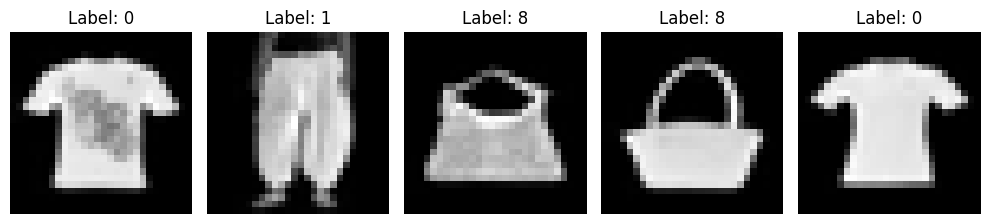

Number of possible classifications: 4

Number of examples for each label:
Label 0: 654 examples
Label 1: 495 examples
Label 5: 853 examples
Label 8: 1609 examples

Data is in range -1 to 1. Scaling to 0 to 1...

Test images reshaped and scaled successfully.
Initializing model architecture...
Training the model...


  4%|▍         | 1/25 [00:07<02:54,  7.27s/it]

Epoch 1/25 - Loss: 1.0433, Val Loss: 0.5444, Train Acc: 0.7964, Val Acc: 0.7902, Val F1: 0.7756


  8%|▊         | 2/25 [00:14<02:41,  7.01s/it]

Epoch 2/25 - Loss: 0.6364, Val Loss: 0.4645, Train Acc: 0.8434, Val Acc: 0.8389, Val F1: 0.8372


 12%|█▏        | 3/25 [00:20<02:30,  6.84s/it]

Epoch 3/25 - Loss: 0.5606, Val Loss: 0.4144, Train Acc: 0.8632, Val Acc: 0.8580, Val F1: 0.8556


 16%|█▌        | 4/25 [00:27<02:20,  6.68s/it]

Epoch 4/25 - Loss: 0.5254, Val Loss: 0.3952, Train Acc: 0.8741, Val Acc: 0.8628, Val F1: 0.8632


 20%|██        | 5/25 [00:33<02:14,  6.71s/it]

Epoch 5/25 - Loss: 0.4979, Val Loss: 0.4025, Train Acc: 0.8726, Val Acc: 0.8613, Val F1: 0.8628


 24%|██▍       | 6/25 [00:41<02:09,  6.83s/it]

Epoch 6/25 - Loss: 0.4751, Val Loss: 0.3823, Train Acc: 0.8788, Val Acc: 0.8674, Val F1: 0.8669


 28%|██▊       | 7/25 [00:47<02:02,  6.80s/it]

Epoch 7/25 - Loss: 0.4608, Val Loss: 0.3862, Train Acc: 0.8793, Val Acc: 0.8644, Val F1: 0.8652


 32%|███▏      | 8/25 [00:54<01:55,  6.78s/it]

Epoch 8/25 - Loss: 0.4450, Val Loss: 0.3708, Train Acc: 0.8858, Val Acc: 0.8718, Val F1: 0.8707


 36%|███▌      | 9/25 [01:01<01:49,  6.83s/it]

Epoch 9/25 - Loss: 0.4356, Val Loss: 0.3664, Train Acc: 0.8912, Val Acc: 0.8766, Val F1: 0.8751


 40%|████      | 10/25 [01:08<01:44,  6.95s/it]

Epoch 10/25 - Loss: 0.4292, Val Loss: 0.3580, Train Acc: 0.8921, Val Acc: 0.8761, Val F1: 0.8752


 44%|████▍     | 11/25 [01:15<01:35,  6.81s/it]

Epoch 11/25 - Loss: 0.4240, Val Loss: 0.3597, Train Acc: 0.8938, Val Acc: 0.8779, Val F1: 0.8772


 48%|████▊     | 12/25 [01:21<01:28,  6.82s/it]

Epoch 12/25 - Loss: 0.4094, Val Loss: 0.3554, Train Acc: 0.8956, Val Acc: 0.8780, Val F1: 0.8772


 52%|█████▏    | 13/25 [01:28<01:20,  6.73s/it]

Epoch 13/25 - Loss: 0.4099, Val Loss: 0.3552, Train Acc: 0.8995, Val Acc: 0.8823, Val F1: 0.8828


 56%|█████▌    | 14/25 [01:37<01:21,  7.44s/it]

Epoch 14/25 - Loss: 0.3980, Val Loss: 0.3491, Train Acc: 0.8994, Val Acc: 0.8812, Val F1: 0.8809


 60%|██████    | 15/25 [01:45<01:16,  7.62s/it]

Epoch 15/25 - Loss: 0.3932, Val Loss: 0.3541, Train Acc: 0.9004, Val Acc: 0.8804, Val F1: 0.8820


 64%|██████▍   | 16/25 [01:53<01:10,  7.84s/it]

Epoch 16/25 - Loss: 0.3938, Val Loss: 0.3445, Train Acc: 0.9031, Val Acc: 0.8797, Val F1: 0.8796


 68%|██████▊   | 17/25 [02:00<01:00,  7.57s/it]

Epoch 17/25 - Loss: 0.3870, Val Loss: 0.3406, Train Acc: 0.9053, Val Acc: 0.8852, Val F1: 0.8856


 72%|███████▏  | 18/25 [02:07<00:50,  7.28s/it]

Epoch 18/25 - Loss: 0.3810, Val Loss: 0.3511, Train Acc: 0.9008, Val Acc: 0.8813, Val F1: 0.8798


 76%|███████▌  | 19/25 [02:14<00:42,  7.12s/it]

Epoch 19/25 - Loss: 0.3770, Val Loss: 0.3404, Train Acc: 0.9063, Val Acc: 0.8842, Val F1: 0.8848


 80%|████████  | 20/25 [02:20<00:35,  7.01s/it]

Epoch 20/25 - Loss: 0.3675, Val Loss: 0.3450, Train Acc: 0.9033, Val Acc: 0.8782, Val F1: 0.8793


 84%|████████▍ | 21/25 [02:27<00:27,  6.94s/it]

Epoch 21/25 - Loss: 0.3698, Val Loss: 0.3386, Train Acc: 0.9050, Val Acc: 0.8833, Val F1: 0.8819


 88%|████████▊ | 22/25 [02:34<00:20,  6.89s/it]

Epoch 22/25 - Loss: 0.3646, Val Loss: 0.3345, Train Acc: 0.9105, Val Acc: 0.8876, Val F1: 0.8867


 92%|█████████▏| 23/25 [02:41<00:13,  6.93s/it]

Epoch 23/25 - Loss: 0.3602, Val Loss: 0.3401, Train Acc: 0.9090, Val Acc: 0.8842, Val F1: 0.8848


 96%|█████████▌| 24/25 [02:48<00:06,  6.91s/it]

Epoch 24/25 - Loss: 0.3550, Val Loss: 0.3440, Train Acc: 0.9082, Val Acc: 0.8841, Val F1: 0.8843


100%|██████████| 25/25 [02:55<00:00,  7.02s/it]

Epoch 25/25 - Loss: 0.3558, Val Loss: 0.3335, Train Acc: 0.9121, Val Acc: 0.8914, Val F1: 0.8914
Saving training and validation graphs...


Evaluating model on test set...
Test Accuracy: 0.7355, Test F1 Score: 0.3591
Saving confusion matrix...
Saving the model...
Process complete!


<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [6]:
# main 


def main():
    # Step 1: Load and Preprocess Data
    print("Loading and preprocessing data...")
    X_train, y_train = load_data(train=True)
    # X_test, y_test = load_data(train=False)
    X_test, y_test = load_test_data()
    
    # Normalize and one-hot encode the labels
    X_train, y_train = preprocess_data(X_train, y_train)
    # X_test, y_test = preprocess_data(X_test, y_test)
    
    # Split validation set from training set
    val_split = int(0.85 * len(X_train))
    X_val, y_val = X_train[val_split:], y_train[val_split:]
    X_train, y_train = X_train[:val_split], y_train[:val_split]
    
    # Step 2: Define Model Architecture
    print("Initializing model architecture...")
    model = NeuralNetwork([
    Dense(784, 256, optimizer=AdamOptimizer(learning_rate=0.003)),
    BatchNormalization(256),
    ReLu(),
    Dropout(0.5),

    Dense(256, 128, optimizer=AdamOptimizer(learning_rate=0.003)),
    BatchNormalization(128),
    ReLu(),
    Dropout(0.4),

    Dense(128, 64, optimizer=AdamOptimizer(learning_rate=0.003)),
    BatchNormalization(64),
    ReLu(),
    Dropout(0.3),

    Dense(64, 32, optimizer=AdamOptimizer(learning_rate=0.003)),
    BatchNormalization(32),
    ReLu(),
    Dropout(0.2),

    Dense(32, 16, optimizer=AdamOptimizer(learning_rate=0.003)),
    BatchNormalization(16),
    ReLu(),
    Dropout(0.1),

    Dense(16, 10, optimizer=AdamOptimizer(learning_rate=0.003)),
    Softmax()
])
    
    # Step 3: Train the Model
    print("Training the model...")
    epochs = 25
    learning_rate = 0.003
    batch_size = 256
    
    epoch_loss, epoch_val_loss, epoch_accuracy, epoch_val_accuracy, epoch_val_f1 = model.fit(
        X_train, y_train, X_val, y_val, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size
    )
    
    # Step 4: Save Training and Validation Graphs
    print("Saving training and validation graphs...")
    model.save_graphs(epoch_loss, epoch_val_loss, epoch_accuracy, epoch_val_accuracy, epoch_val_f1)
    
    # Step 5: Evaluate Model on Test Set
    print("Evaluating model on test set...")
    test_accuracy, test_f1 = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")
    
    # Step 6: Save Confusion Matrix for Test Set
    print("Saving confusion matrix...")
    model.save_confusion_matrix(X_test, y_test, filename="confusion_matrix.png")
    
    # Step 7: Save the Model
    print("Saving the model...")
    model.save_model(filename="trained_model.pkl")
    
    print("Process complete!")

# Run the main function
if __name__ == "__main__":
    main()

